In [23]:
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

In [24]:
hrrr = Herbie(
    "2025-09-25 12:00", 
    model="hrrr", 
    product="sfc", 
    fxx=6
)

rtma = Herbie("2025-09-25 18:00", 
           model="rtma", 
           product="anl"
)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Sep-25 12:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=rtma ┊ product=anl ┊ 2025-Sep-25 18:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


In [25]:
ds_hrrr = hrrr.xarray("TMP:2 m above")
ds_hrrr

<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-09-25T12:00:00
    step                 timedelta64[ns] 8B 06:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-09-25T18:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 296.0 296.0 296.0 ... 286.8 286.9
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/john_b_needham/data/hrrr/20250925/subset_...
    search:                  TMP:2 m above

In [26]:
ds_rtma = rtma.xarray("TMP:2 m above")
ds_rtma

<xarray.Dataset> Size: 75MB
Dimensions:              (y: 1597, x: 2345)
Coordinates:
    time                 datetime64[ns] 8B 2025-09-25T18:00:00
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 30MB 19.23 19.23 19.24 ... 54.38 54.37
    longitude            (y, x) float64 30MB 233.7 233.7 233.8 ... 300.9 301.0
    valid_time           datetime64[ns] 8B 2025-09-25T18:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 15MB 296.5 296.5 296.7 ... 289.0 289.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   rtma
    product:                 anl
    description:             CONUS Real-Time Mesoscale Analysis (RTMA)
    remote_grib:             /Users/john_b_needham/data/rtma/20250925/rtma2p5...
    local_grib:              /Users/john_b_needham/data/rtma/20250925/subset_...
    search:                  TMP:2 m above

In [ ]:
# ensure x and y exist as coordinates
ds_rtma = ds_rtma.assign_coords(x=ds_rtma.x, y=ds_rtma.y)
ds_hrrr = ds_hrrr.assign_coords(x=ds_hrrr.x, y=ds_hrrr.y)

rtma_on_hrrr = ds_rtma.interp_like(ds_hrrr)

True

In [34]:
rtma_on_hrrr.sizes["x"] == ds_hrrr.sizes["x"]  # -> 1799

True

In [35]:
rtma_on_hrrr.sizes["y"] == ds_hrrr.sizes["y"]  # -> 1059

True

Text(1.0, 1.0, '2 metre temperature')

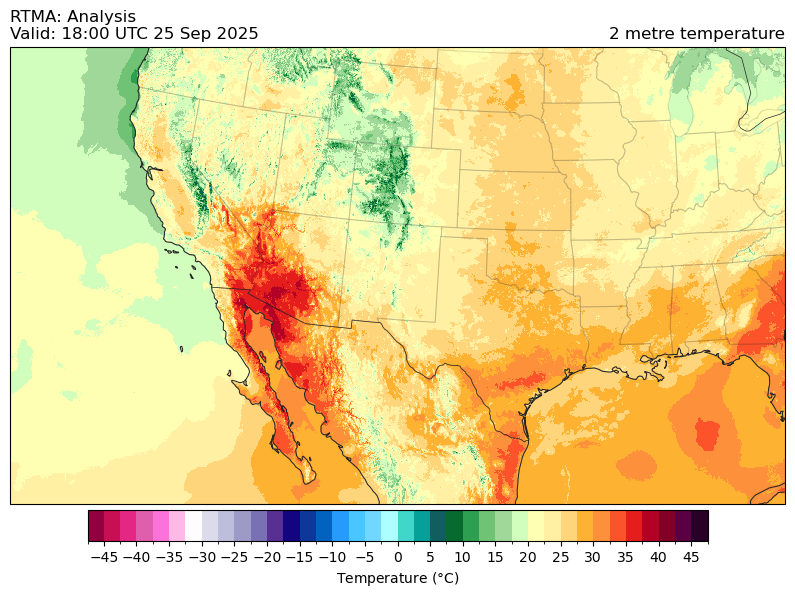

In [ ]:
ax = EasyMap("50m", crs=ds_rtma.herbie.crs, figsize=[10, 8]).BORDERS().STATES().ax

p = ax.pcolormesh(
    ds_hrrr.longitude,
    ds_hrrr.latitude,
    rtma_on_hrrr.t2m - 273.15,
    transform=pc,
    **paint.NWSTemperature.kwargs2,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **paint.NWSTemperature.cbar_kwargs2,
)

ax.set_title(
    f"{rtma_on_hrrr.model.upper()}: {rtma.product_description}\nValid: {rtma_on_hrrr.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds_rtma.t2m.GRIB_name, loc="right")